In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
import pandas as pd
import scipy as scp
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import pickle
import matplotlib.gridspec as gridspec


<h2 style="font-size:28px; font-weight:bold;">Preparing Data</h2>

In [2]:
file_path1 = 'SSTs.nc'
file_path2 = 'TCs.nc'
  
#Opening dataset for tropics                                   
ds1 = xr.open_dataset(file_path1)
ds2 = xr.open_dataset(file_path2)

/Users/varinradia/anaconda3/lib/python3.11/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [3]:
ds_grouped = ds1.groupby('time.year').mean(dim='time')                                   #Obtained Yearly Meaned Data
tropical_data = ds_grouped.sel(latitude=slice(23.5, -23.5), longitude=slice(0, 360))    #Extracted Data For the Tropics

<h2 style="font-size:28px; font-weight:bold;">Obtaining masked SST data for each year</h2>

In [8]:
SSTs = {}

# Iterating over each year in the tropical_data
for year, data in tropical_data.groupby('year'):
    # Get the SST data for the current year
    sst_data = data['sst']
    
    # Calculating the tropical mean SST for the year
    tropical_mean_sst = sst_data.mean(dim=['latitude', 'longitude'], skipna=True)
    
    # Creating a mask where SST exceeds the tropical mean SST for the current year
    up = sst_data > tropical_mean_sst
    
    # Selecting the SST data where the mask is True
    masked_sst = sst_data.where(up)

    # Storing the masked SST data for the current year
    SSTs[int(year)] = masked_sst

In [5]:
with open("storms_by_year.pk", "rb") as fin:  # Loading in the dictionary consitsing of Storm IDs with year as key, created in SSTs2
 storms = pickle.load(fin)

<h2 style="font-size:28px; font-weight:bold;">Exctracting lat and lon data for each storm that were sorted by year</h2>

In [6]:
# Initializing a dictionary to store information with latitudes and longitudes
storm_info = {}

# Iterating over the years in the dictionary
for year, storm_ids_year in storms.items():
    # Initializing a dictionary to store storm information for the current year
    storm_info_year = {}
    # Iterating over the storm IDs for the current year
    for storm_id in storm_ids_year:
        # Finding the storm data for the current storm ID
        storm_data = ds2.sel(storm=storm_id)
        # Extracting latitude and longitude values
        latitudes = storm_data['lat'].values
        longitudes = storm_data['lon'].values
        # Storing latitude and longitude values in the storm_info_year dictionary
        storm_info_year[storm_id] = {'lat': latitudes, 'lon': longitudes}
    # Storing storm information for the current year in the storm_info dictionary
    storm_info[year] = storm_info_year


<h2 style="font-size:28px; font-weight:bold;">Creating plots with masked SSTs and TCs for each year</h2>

<h2 style="font-size:21px; font-weight:bold;">Displaying plots for 1971-1981 for now to reduce file size</h2>

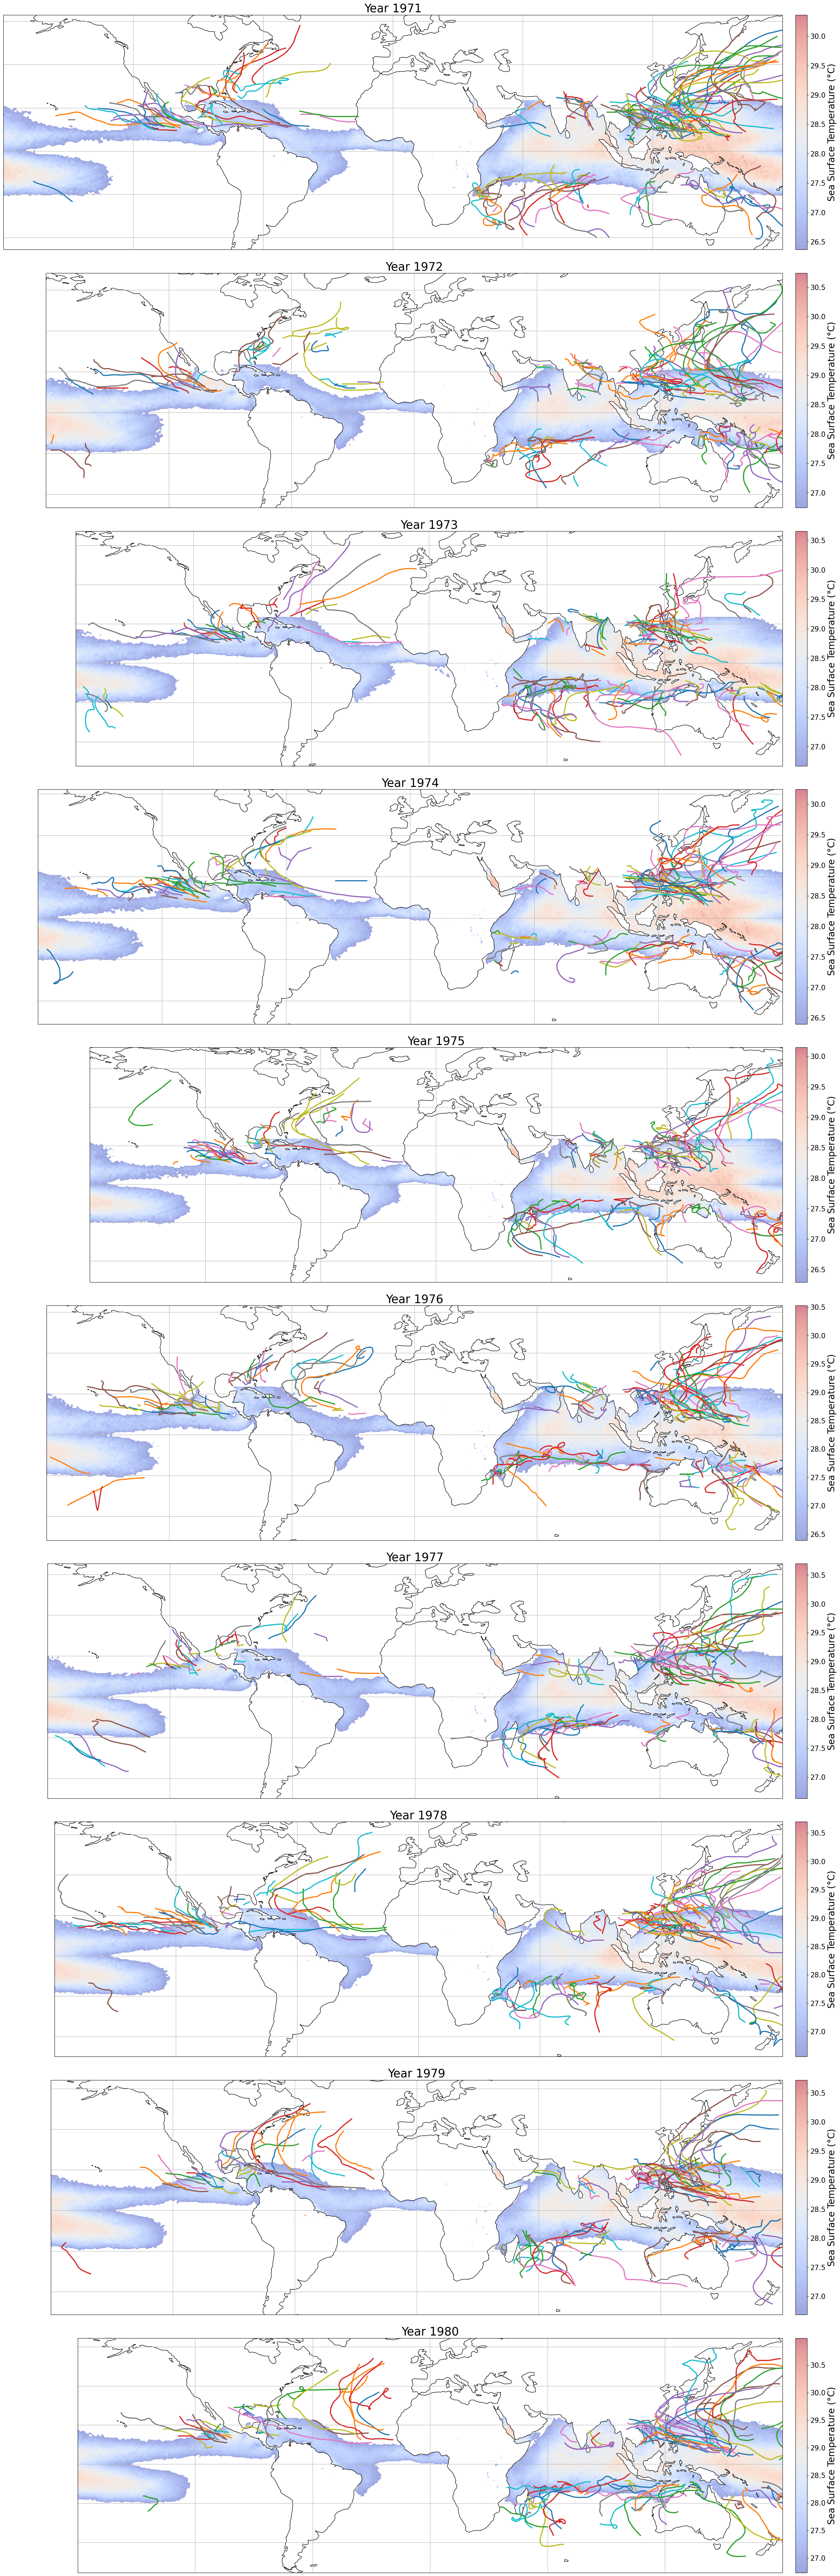

In [7]:

# Create a figure with subplots for each year (up to 50 years)
fig, axs = plt.subplots(10, 1, figsize=(50, 100), subplot_kw={'projection': ccrs.PlateCarree()})
                        

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Flatten the axs array to iterate over all subplots
axs = axs.flatten()

# Iterate over each year from 1971 to 2021 or until the 50th subplot
for i, year in enumerate(range(1971, 1981)):
    if i >= 50:
        break
    
    # Extract storm latitude and longitude data for the current year
    year_storms = storm_info.get(year, {})
    
    # Get the corresponding axis for the current subplot
    ax = axs[i]
    
    # Plot storm locations on the map for the current year
    for storm_id, data in year_storms.items():
        latitudes = data['lat']
        longitudes = data['lon']
        ax.plot(longitudes, latitudes, linestyle='-', label=f'Storm {storm_id}', linewidth=2.5)
    
    # Get the SST data for the current year
    sst_data = SSTs.get(year, None)
    
    # Add SST data if available for the current year
    if sst_data is not None:
        pcm = ax.pcolormesh(sst_data['longitude'], sst_data['latitude'], sst_data-273.15, cmap='coolwarm', alpha=0.5)
        
        # Add color bar
        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.01)
        cbar.set_label('Sea Surface Temperature (°C)', fontsize=20)
        cbar.ax.tick_params(labelsize=15)
    
    # Add map features
    ax.coastlines()
    ax.gridlines()
    ax.set_title(f'Year {year}', fontsize=25)

# Show the plot
plt.show()



<h2 style="font-size:24px; font-weight:bold;">Plot examination</h2>

<div style="font-size:18px;">
<p>The analysis shows that most tropical cyclones form in areas where sea surface temperatures are above the average for tropical regions. The region with the most tropical cyclones are the Western North Pacific and the Eastern Indian Ocean. However, the North Atlantic is an exception to this trend, with cyclone formation not strictly following the pattern of higher local temperatures. 
</p>
</div>